In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from shapely.geometry import Polygon

from sklearn.metrics import accuracy_score

### Support Vector Machines (SVM)

In this notebook, we will create a Linear SVM or Support Vector Classifier (SVC). We initialize the data and check if it's linearly separable. Linear separability can be found by building convex hulls for points from different labels and checking if they intersect or not. If they intersect, that means the data is not linearly separable.

A convex hull is a convex polygon/envelope that spans/encloses all the given input points while being the smallest set.

We then use gradient descent to build SVC from scratch using loss as a mixture of hinge loss and maximizing margin.

In [2]:
def check_linearly_separable(X, pos_idx, neg_idx):
    X_pos = X[pos_idx]
    X_neg = X[neg_idx]

    # need at least 3 points to make initial simplex
    if (len(X_pos) < 3 or len(X_neg) < 3):
        return False

    hull_pos = ConvexHull(X_pos)
    hull_neg = ConvexHull(X_neg)
    poly1 = Polygon(X_pos[hull_pos.vertices])
    poly2 = Polygon(X_neg[hull_neg.vertices])
    return not poly1.intersects(poly2)

def initialize_data(low, high, n_pts):
    X = np.random.uniform(low=low, high=high, size=(n_pts,2))
    Y = np.random.randint(0, 2, n_pts)
    Y = 2 * Y - 1
    pos_idx = np.where(Y==1)[0]
    neg_idx = np.where(Y==-1)[0]
    return X, Y, pos_idx, neg_idx
    
def make_data(low, high, n_pts):
    separable = False
    while not separable:
        X, Y, pos_idx, neg_idx = initialize_data(low, high, n_pts)
        separable = check_linearly_separable(X, pos_idx, neg_idx)
    return X, Y

In [3]:
low = -100
high = 100
n_pts = 25

X, Y = make_data(low, high, n_pts)

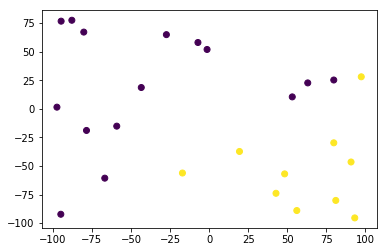

In [4]:
plt.scatter(X[:,0], X[:,1], c=Y)
plt.show()

In [5]:
def plotting(W, B, costs):
    plt.figure(figsize=(20,5))
    plt.subplot(141)
    plt.title('W1')
    plt.plot(W[:,0])

    plt.subplot(142)
    plt.title('W2')
    plt.plot(W[:,1])

    plt.subplot(143)
    plt.title('B')
    plt.plot(B)    

    plt.subplot(144)
    plt.title('costs')
    plt.plot(costs)
    plt.show()

In [6]:
def loss_fn(w,b,X,Y,reg_coef):
    hinge_loss = 1 - Y * (X @ w + b)
    loss = reg_coef * w.T @ w / 2 + sum(hinge_loss[hinge_loss > 0])
    return loss

def gradient(w,b,X,Y,reg_coef):
    idx = list(range(len(Y)))
    idx1 = np.where(Y * (X @ w + b) >= 1)[0]
    idx2 = list(set(idx) - set(idx1)) 

    dw = reg_coef * w - Y[idx2] @ X[idx2]
    db = -sum(Y[idx2])
    return dw, db

def gradient_descent(w_init, b_init, alpha, reg_coef, max_iters, eps):
    w = w_init
    b = b_init
    dw = np.random.normal(w_init.shape)
    db = np.random.random()

    W = []
    B = []
    costs = []
    n_iters = 0
    terminated_flag = 0
    while np.linalg.norm(dw)>eps:
        dw, db = gradient(w,b,X,Y,reg_coef)
        w = w-alpha*dw
        b = b-alpha*db

        cost = loss_fn(w,b,X,Y,reg_coef)
        W.append(w)
        B.append(b)
        costs.append(cost)
        n_iters +=1
        if n_iters > max_iters:
            terminated_flag = 1
            break
    if terminated_flag:
        print(f'Terminated at {max_iters} iterations..')
    else:
        print(f'Converged at {n_iters} iterations..')
    return np.array(W), np.array(B), np.array(costs)

Terminated at 5000 iterations..


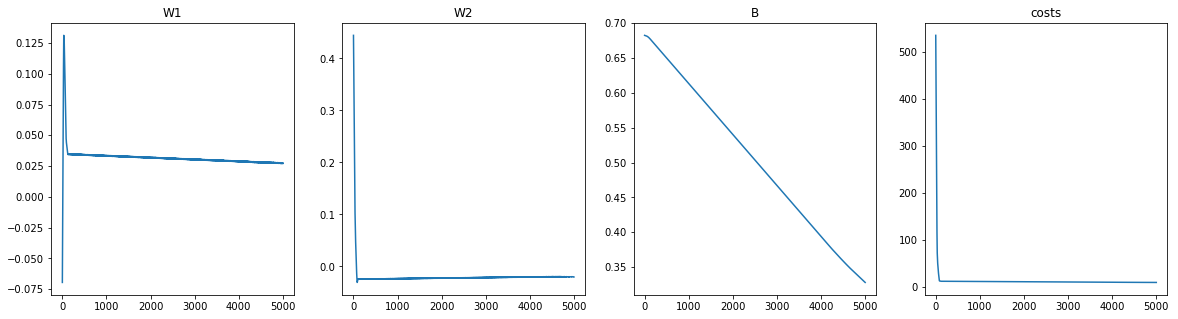

In [7]:
w_init = np.random.normal(size = (X.shape[1]))
b_init = np.random.random()
alpha = 1E-5
reg_coef = 0
max_iters = 5000
eps = 1E-3
W, B, costs = gradient_descent(w_init, b_init, alpha, reg_coef, max_iters, eps)

plotting(W, B, costs)

Terminated at 5000 iterations..


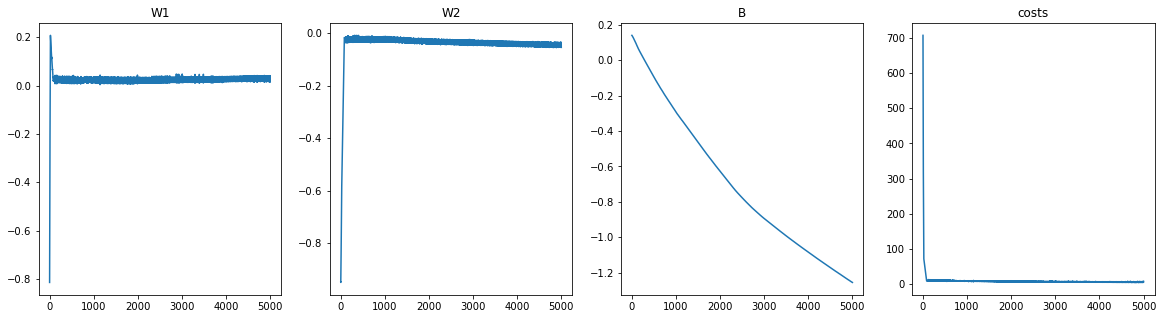

In [8]:
w_init = np.random.normal(size = (X.shape[1]))
b_init = np.random.random()
alpha = 1E-4
reg_coef = 0.25
max_iters = 5000
eps = 1E-3
W, B, costs = gradient_descent(w_init, b_init, alpha, reg_coef, max_iters, eps)

plotting(W, B, costs)

In [9]:
y_pred = (X @ W[-1] + B[-1] > 0) * 1
y_pred = 2 * y_pred - 1

print('Accuracy Score:', accuracy_score(Y, y_pred))

Accuracy Score: 0.88


### Plotting Decision Boundaries

We will now plot decision boundary and check for misclassification. Decision Boundary is plotted by looking at target values (Y) over a fine-grained mesh.

In [10]:
def get_grid(x, grid_width):
    min_x, max_x = min(x), max(x)
    grid_x = np.arange(min_x, max_x, grid_width)
    return grid_x

def get_mesh_predictions(X, grid_width):
    # building grid
    grid_x1 = get_grid(X[:,0], grid_width)
    grid_x2 = get_grid(X[:,1], grid_width)

    # building mesh
    x1, x2 = np.meshgrid(grid_x1, grid_x2)

    # getting predictions for each point in mesh
    grid_X = np.vstack((x1.ravel(), x2.ravel())).transpose()
    grid_Y = (grid_X @ W[-1] + B[-1] >= 0) * 1
    grid_Y = grid_Y.reshape(x1.shape)
    return x1, x2, grid_Y

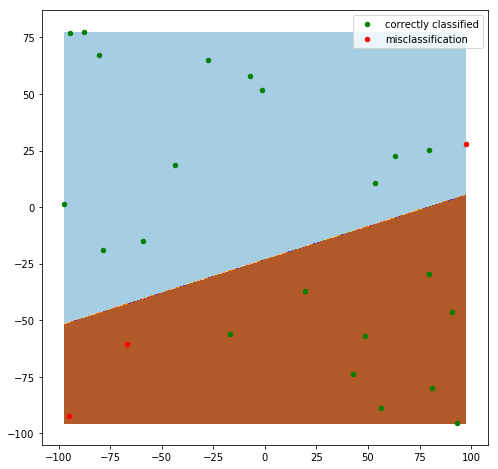

In [11]:
plt.figure(figsize=(8,8))

grid_width = 0.5
grid_X1, grid_X2, grid_Y = get_mesh_predictions(X, grid_width)
plt.contourf(grid_X1, grid_X2, grid_Y, cmap='Paired')

correct = np.where(y_pred==Y)[0]
incorrect = np.where(y_pred!=Y)[0]
plt.scatter(X[correct, 0], X[correct,1], c='g', label='correctly classified', s=20)
plt.scatter(X[incorrect, 0], X[incorrect,1], c='r', label='misclassification', s=20)
plt.legend()
plt.show()